In [1]:
import os

import pandas as pd
import numpy as np
from numpy import array
import pandas_datareader.data as pdr 

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import plotly.express as px
import plotly.graph_objects as go
from scipy.ndimage import zoom

import seaborn as sns
plt.style.use('seaborn-whitegrid')
from pylab import rcParams
%matplotlib inline
import itertools

import warnings 
warnings.filterwarnings(action='ignore')

import scipy.stats
from scipy.stats import norm,t

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

In [2]:
#한글폰트 적용
import matplotlib.font_manager as fm
path = 'C:/Windows/Fonts/gulim.ttc'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

In [3]:
pd.set_option('display.max_columns', None)
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
print(data.shape)
data.head()

(270, 10)


,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2000-01-31,570720,1319,1.913430,2.878875,4.039038,55.0,-218.1,1131.07,181367,133.88
2000-02-29,590400,1531,1.986905,2.882456,4.005537,51.9,-324.1,1128.80,218300,130.56
2000-03-31,665430,1660,2.050943,2.884831,4.038299,58.7,275.3,1117.19,206116,128.19
2000-04-30,603930,1628,2.107499,2.887110,4.030758,56.9,-1156.0,1109.76,166931,126.84
2000-05-31,683880,1566,2.158143,2.890466,4.022112,59.6,1535.5,1120.01,208853,127.89


In [4]:
split = -60
train_data = data['TEU'][0:split] 
test_data = data['TEU'][split:]

In [5]:
train_data.shape,test_data.shape

((210,), (60,))

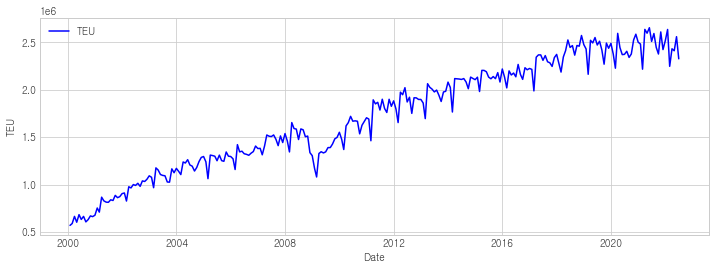

In [6]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(data['TEU'], 'blue', label='TEU')
plt.legend()

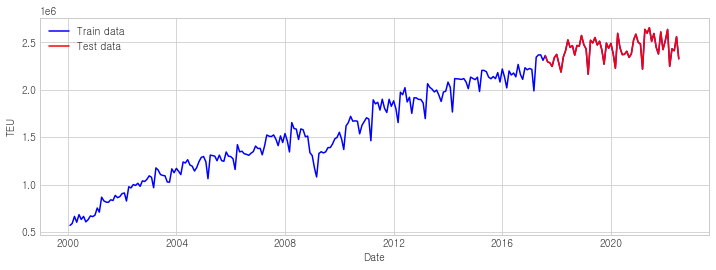

In [7]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(data['TEU'], 'blue', label='Train data')
plt.plot(test_data, 'red', label='Test data')
plt.legend()

In [8]:
seasonal = pd.read_csv('계절성예측.csv')

In [9]:
pd.set_option('display.max_columns', None)
trend = pd.read_csv('TEU분해.csv')
trend['Date'] = pd.to_datetime(trend['Date'])
trend = trend.set_index('Date')
print(trend.shape)
trend.head()

(60, 1)


,TEU_Trend
Date,
2017-07-31,2291408.583
2017-08-31,2302073.625
2017-09-30,2310450.375
2017-10-31,2312407.958
2017-11-30,2320814.042


### 2. 다변량 LSTM

In [10]:
import tensorflow 
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense,Flatten,Dropout,GRU,Bidirectional,RepeatVector,TimeDistributed

In [11]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

In [12]:
import random
random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

In [13]:
tf.random.uniform([1]).numpy()

array([0.5380393], dtype=float32)

In [14]:
raw_df = data

In [15]:
split = -80
train = raw_df[0:split] 
test = raw_df[split:] 

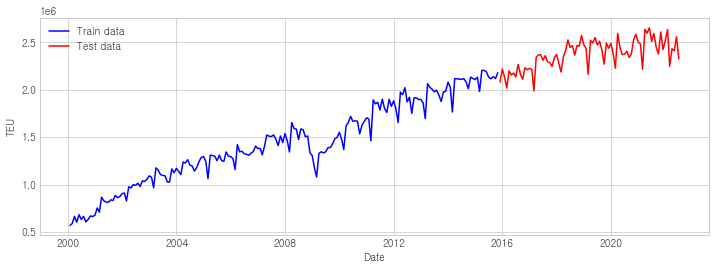

In [16]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(train['TEU'], 'blue', label='Train data')
plt.plot(test['TEU'], 'red', label='Test data')
plt.legend()

In [17]:
len(train),len(test)

(190, 80)

In [18]:
data.columns

Index(['TEU', 'BDI', 'ln(HRCI)', 'ln(SCFI)', 'ln(다우존스지수)', '전산업생산지수', '경상수지',
       '환율', '화물수송총괄', '수출물가지수'],
      dtype='object')

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scale_cols =  ['TEU','BDI', 'ln(HRCI)', 'ln(SCFI)','수출물가지수','환율','전산업생산지수','경상수지','ln(다우존스지수)','화물수송총괄']
scaled_train = scaler.fit_transform(train[scale_cols])  
scaled_train = pd.DataFrame(scaled_train, columns=scale_cols)

feature_train = scaled_train                       # X_train 다변량 시계열 변수 
label_train = scaled_train[['TEU']]               #  y_train 종속변수 

scaled_test = scaler.fit_transform(test[scale_cols]) 
scaled_test = pd.DataFrame(scaled_test, columns=scale_cols)

feature_test = scaled_test                       # X_test 다변량 시계열 변수 
label_test = scaled_test[['TEU']]               #  y_test종속변수 

In [20]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [21]:
window_size = 20 # Input Sequence (입력 길이) : X1,X2,....XT 
n_step_out = 60   # Output Sequence (출력 길이) : Y1,Y2,....YT

### 1. X_train, Y_train 배열

In [22]:
X_train,y = split_sequence(feature_train, window_size, n_step_out) # feature_train = X 다변량 변수 
x, Y_train = split_sequence(label_train, window_size, n_step_out) # label_train = Y 종속변수 예측값 

In [23]:
X_train.shape,Y_train.shape

((111, 20, 10), (111, 60, 1))

### 2. X_test,Y_test 배열

In [24]:
X_test,y = split_sequence(feature_test, window_size, n_step_out) # feature_train = X 다변량 변수 
x, Y_test = split_sequence(label_test, window_size, n_step_out) # label_train = Y 종속변수 예측값 

In [25]:
X_test.shape,Y_test.shape

((1, 20, 10), (1, 60, 1))

In [26]:
class MCDropout(Dropout): # 몬테카를로 드롭아웃 
    def call(self, inputs):
        return super().call(inputs, training=True)

In [27]:
model = Sequential() # Encoder & Decoder

## Encoder state
model.add(LSTM(64,activation='tanh',input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=False))
model.add(MCDropout(0.8))
model.add(Dense(1))
model.add(RepeatVector(60)) # 출력 개수만큼 반복 

## Decoder State
model.add(LSTM(64, activation='tanh', return_sequences=True)) # Decoder State 
model.add(MCDropout(0.8))
model.add(TimeDistributed(Dense(8,activation='relu'))) 
model.add(TimeDistributed(Dense(1)))

model.compile(loss='mean_squared_error', optimizer='adam',metrics='mae')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_train, Y_train, epochs= 200, batch_size=10, validation_split=0.02,callbacks=[early_stop])

Epoch 1/200
11/11 [==============================] - 7s 422ms/step - loss: 0.3746 - mae: 0.5743 - val_loss: 0.2985 - val_mae: 0.5153
Epoch 2/200
11/11 [==============================] - 0s 37ms/step - loss: 0.1397 - mae: 0.3012 - val_loss: 0.2345 - val_mae: 0.4465
Epoch 3/200
11/11 [==============================] - 0s 34ms/step - loss: 0.0925 - mae: 0.2505 - val_loss: 0.1773 - val_mae: 0.3767
Epoch 4/200
11/11 [==============================] - 0s 36ms/step - loss: 0.0730 - mae: 0.2128 - val_loss: 0.1544 - val_mae: 0.3538
Epoch 5/200
11/11 [==============================] - 0s 38ms/step - loss: 0.0576 - mae: 0.1929 - val_loss: 0.1104 - val_mae: 0.2921
Epoch 6/200
11/11 [==============================] - 0s 36ms/step - loss: 0.0547 - mae: 0.1879 - val_loss: 0.1379 - val_mae: 0.3137
Epoch 7/200
11/11 [==============================] - 0s 38ms/step - loss: 0.0483 - mae: 0.1735 - val_loss: 0.1227 - val_mae: 0.3151
Epoch 8/200
11/11 [==============================] - 1s 48ms/step - loss: 0

In [28]:
rcParams['figure.figsize'] = 12, 4

<AxesSubplot:>

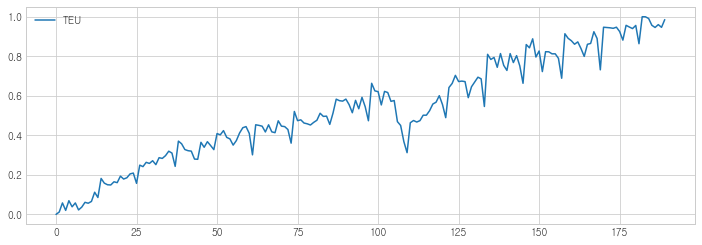

In [29]:
label_train.plot()

<AxesSubplot:>

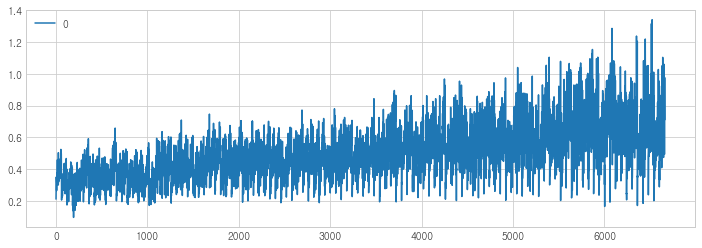

In [30]:
pd.DataFrame(model.predict(X_train).reshape(-1,1)).plot()

### Test 데이터 Sequence 반복 이동 예측 ( 총합 5번 시행)

In [31]:
X_test_1 = np.array(feature_test.head(20)).reshape((1,20, 10)) 

In [32]:
model_MC=  model
prediction = [model_MC.predict(X_test_1) for sample in range(30)]

In [33]:
dfs = [] # List 
for i in range(30): # 100번 반복 실험 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,10, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)

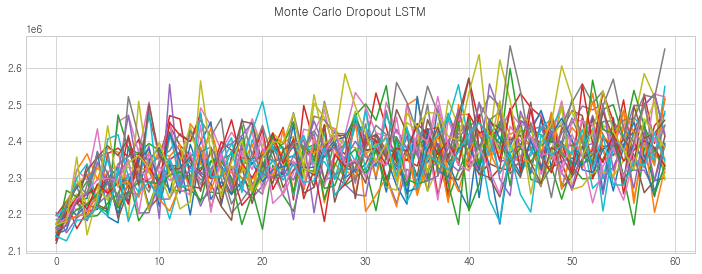

In [34]:
rcParams['figure.figsize'] = 12, 4
plt.suptitle('Monte Carlo Dropout LSTM')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [35]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])

In [36]:
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [38]:
np.mean(df.std()/df.mean())

0.03451700508594513

In [40]:
df.to_csv('60개월2.csv')

In [39]:
rmse = math.sqrt(mean_squared_error(trend.reset_index()['TEU_Trend'], df.transpose().mean()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend.reset_index()['TEU_Trend']- df.transpose().mean())/ trend.reset_index()['TEU_Trend'])*100) )

RMSE: 90947.27973885639
MAPE: 3.479102878205211


In [39]:
rmse = math.sqrt(mean_squared_error(trend.reset_index()['TEU_Trend'], df.transpose().median()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend.reset_index()['TEU_Trend']- df.transpose().median())/ trend.reset_index()['TEU_Trend'])*100) )

RMSE: 93676.12074047646
MAPE: 3.599876751827099


In [40]:
df2 = pd.read_csv('TEU분해.csv')
df2['Date'] = pd.to_datetime(df2['Date'])
df2.columns

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-07-31,2145454.0,2150991.75,2139099.0,2196192.25,2128412.25,2148839.75,2138375.0,2127611.25,2175746.5,2159984.5,2171666.25,2138168.5,2131510.5,2163161.25,2204514.0,2140076.5,2152438.5,2185076.5,2175629.5,2195755.5,2136906.5,2155673.0,2163444.5,2128738.5,2157793.0,2119987.0,2172321.75,2162655.5,2170274.25,2139744.25


In [41]:
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data.head(1)

,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2000-01-31,570720,1319,1.91343,2.878875,4.039038,55.0,-218.1,1131.07,181367,133.88


Mean RMSE: 134149.35350588878
Mean MAPE: 4.5788794040244305


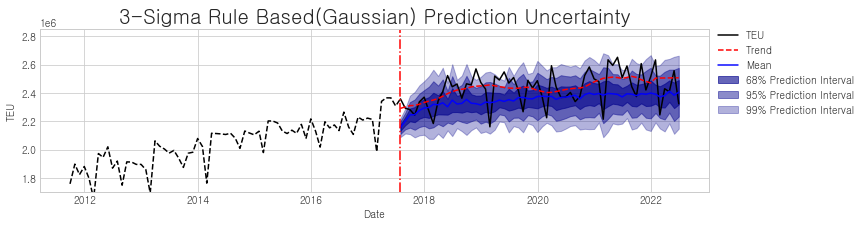

In [42]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.title('3-Sigma Rule Based(Gaussian) Prediction Uncertainty',fontsize=20)
plt.ylim(1.7e6,2.85e6)
plt.plot(data['TEU'].iloc[140:211], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[210:], 'black', label='TEU')
plt.plot(trend,color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='blue',alpha=10.0)
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='darkblue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='darkblue', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='darkblue', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='darkblue',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.reset_index()['TEU'], df.transpose().mean()))
print('Mean RMSE:',rmse)
print('Mean MAPE:',np.mean(np.abs((test_data.reset_index()['TEU']- df.transpose().mean())/ test_data.reset_index()['TEU'])*100) )

In [43]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.head(60).reset_index()['TEU']
UCL = df.transpose().mean() + 2*df.transpose().std()
LCL = df.transpose().mean() - 2*df.transpose().std()

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
CP

0.6166666666666667

In [44]:
# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.reset_index()['TEU_Trend']
UCL = df.transpose().mean() + 1*df.transpose().std()
LCL = df.transpose().mean() - 1*df.transpose().std()

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
CP

0.36666666666666664

In [45]:
#68% Interval sharpness score

lower = (df2.transpose().mean() - 1*df2.transpose().std()).values
upper = (df2.transpose().mean() + 1*df2.transpose().std()).values

sharpness = []
for i in range(0,60):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 68% Interval Sharpness',np.mean(np.array(sharpness)))

#68% Interval sharpness score

lower = df2.transpose().quantile(0.15).values
upper = df2.transpose().quantile(0.85).values

sharpness = []
for i in range(0,60):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 70% Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 68% Interval Sharpness 139565.66
Quantile 70% Interval Sharpness 138081.2345833333


Median RMSE: 136499.38099464824
Median MAPE: 4.672310504643568


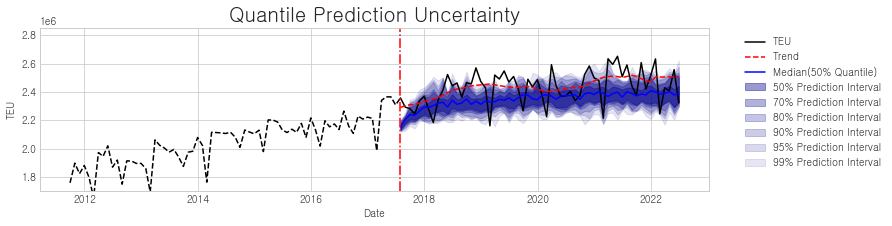

In [46]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.title('Quantile Prediction Uncertainty',fontsize=20)
plt.ylim(1.7e6,2.85e6)
plt.plot(data['TEU'].iloc[140:211], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[210:], 'black', label='TEU')
plt.plot(trend,color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median(50% Quantile)',color='blue')
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='darkblue', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='darkblue', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='darkblue', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='darkblue', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='darkblue', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='darkblue', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.reset_index()['TEU'], df.transpose().quantile(0.5)))
print('Median RMSE:',rmse)
print('Median MAPE:',np.mean(np.abs((test_data.reset_index()['TEU']- df.transpose().quantile(0.5))/ test_data.reset_index()['TEU'])*100) )

In [47]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.head(60).reset_index()['TEU']
UCL = df.transpose().quantile(0.975)
LCL = df.transpose().quantile(0.025)

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
CP

0.55

In [48]:
# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.reset_index()['TEU_Trend']
UCL = df.transpose().quantile(0.85)
LCL = df.transpose().quantile(0.15)

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
CP

0.38333333333333336

RMSE: 133650.8690654186
MAPE: 4.462356940676568


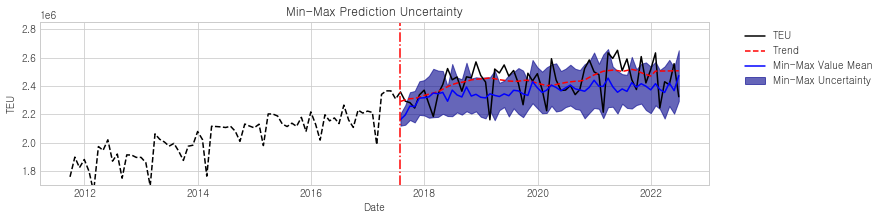

In [49]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.title('Min-Max Prediction Uncertainty')
plt.ylim(1.7e6,2.85e6)
plt.plot(data['TEU'].iloc[140:211], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[210:], 'black', label='TEU')
plt.plot(trend,color='red',label='Trend',linestyle='dashed')
plt.plot((df2.transpose().max()+df2.transpose().min())/2,color='blue',label='Min-Max Value Mean')
plt.plot((df2.transpose().max()+df2.transpose().min())/2 - (df2.transpose().max()-df2.transpose().min())/2,color='darkblue',alpha=0)
plt.plot((df2.transpose().max()+df2.transpose().min())/2 + (df2.transpose().max()-df2.transpose().min())/2,color='darkblue',alpha=0)
plt.fill_between(df2.transpose().mean().index,df2.transpose().min(),df2.transpose().max(),color='darkblue',alpha=0.6, label='Min-Max Uncertainty')
plt.plot()
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')

rmse = math.sqrt(mean_squared_error(test_data.reset_index()['TEU'], (df.transpose().max()+df.transpose().min())/2))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.reset_index()['TEU']- (df.transpose().max()+df.transpose().min())/2)/ test_data.reset_index()['TEU'])*100) )

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [50]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.head(60).reset_index()['TEU']
UCL = (df.transpose().max()+df.transpose().min())/2 + (df.transpose().max()-df.transpose().min())/2
LCL = (df.transpose().max()+df.transpose().min())/2 - (df.transpose().max()-df.transpose().min())/2

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
CP

0.6333333333333333

In [51]:
#95% Interval sharpness score

lower = (df2.transpose().mean() - 2*df2.transpose().std()).values
upper = (df2.transpose().mean() + 2*df2.transpose().std()).values

sharpness = []
for i in range(0,60):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 95% Interval Sharpness',np.mean(np.array(sharpness)))

#95% Interval sharpness score

lower = df2.transpose().quantile(0.025).values
upper = df2.transpose().quantile(0.975).values

sharpness = []
for i in range(0,60):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 95% Interval Sharpness',np.mean(np.array(sharpness)))

lower = df2.transpose().min().values
upper = df2.transpose().max().values

sharpness = []
for i in range(0,60):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Min Max Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 95% Interval Sharpness 279131.3
Quantile 95% Interval Sharpness 241798.08666666664
Min Max Interval Sharpness 288599.7


In [52]:
import CRPS.CRPS as pscore

In [53]:
crps = []

for i in range(0,60):
    crps,fcrps,acrps = pscore(df.transpose()[i],test_data.tail(60).reset_index()['TEU'][i],adjusted_ensemble_size=30).compute()
    print(np.array(crps)) 

190215.385
75452.44611111112
24692.05916666667
13947.615555555556
41483.747777777775
50354.50277777778
19846.38472222222
91588.00944444444
18748.893888888884
55482.23027777778
188949.62333333332
58301.50277777778
109966.54722222223
25633.369444444445
74318.1725
94788.27055555554
214489.5872222222
121698.69444444444
57859.22527777778
129645.79444444447
148574.46055555553
113322.09527777777
180555.54916666666
75205.93055555556
133328.57666666666
31618.19666666667
66731.46611111112
98476.49472222223
55090.66638888888
68150.79333333332
15454.872499999998
117869.71527777778
178861.5725
58960.09527777777
17201.311944444446
18783.44722222222
21899.425555555554
26140.008888888893
19986.36777777777
92878.3636111111
138305.23555555556
76688.97888888889
53866.60805555556
120281.3475
192189.61833333335
161421.61444444442
222790.09999999998
99879.4025
164825.9575
34305.39166666666
20197.684999999998
175844.42694444445
28361.759166666663
69624.5302777778
206437.06666666665
86610.60305555558
27583.15

In [54]:
a = np.array([190215.385,
75452.44611111112,
24692.05916666667,
13947.615555555556,
41483.747777777775,
50354.50277777778,
19846.38472222222,
91588.00944444444,
18748.893888888884,
55482.23027777778,
188949.62333333332,
58301.50277777778,
109966.54722222223,
25633.369444444445,
74318.1725,
94788.27055555554,
214489.5872222222,
121698.69444444444,
57859.22527777778,
129645.79444444447,
148574.46055555553,
113322.09527777777,
180555.54916666666,
75205.93055555556,
133328.57666666666,
31618.19666666667,
66731.46611111112,
98476.49472222223,
55090.66638888888,
68150.79333333332,
15454.872499999998,
117869.71527777778,
178861.5725,
58960.09527777777,
17201.311944444446,
18783.44722222222,
21899.425555555554,
26140.008888888893,
19986.36777777777,
92878.3636111111,
138305.23555555556,
76688.97888888889,
53866.60805555556,
120281.3475,
192189.61833333335,
161421.61444444442,
222790.09999999998,
99879.4025,
164825.9575,
34305.39166666666,
20197.684999999998,
175844.42694444445,
28361.759166666663,
69624.5302777778,
206437.06666666665,
86610.60305555558,
27583.159999999996,
18891.565000000006,
123539.9036111111,
39571.537777777776])

In [55]:
a.shape

(60,)

In [56]:
np.mean(a)

87629.46606481481

In [57]:
1-(67890.706/76450.844)

0.11196917590602395

In [58]:
1-(67890.706/100735.97)

0.32605298782550063

In [59]:
1-(67890.706/85777.986)

0.20852996012286884

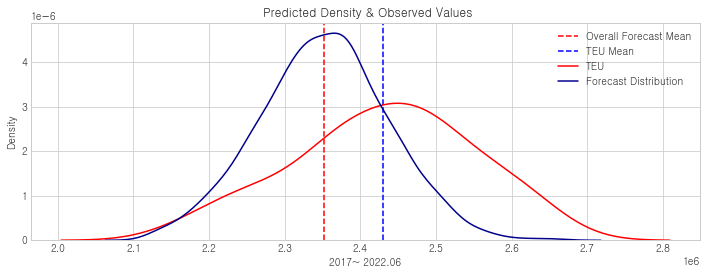

In [60]:
plt.figure(figsize=(12,4))
plt.title(' Predicted Density & Observed Values')
plt.axvline(x=df.transpose().mean().mean(), color='red',linestyle='dashed',label='Overall Forecast Mean')
plt.axvline(x=test_data.mean(), color='blue',linestyle='dashed',label='TEU Mean')
sns.distplot(test_data.reset_index()['TEU'],color='red',label='TEU',hist=False)
sns.distplot(df.transpose(),color='darkblue',label='Forecast Distribution',hist=False)
plt.xlabel('2017~ 2022.06')
plt.legend()

In [61]:
def KL(p,q):
    return(np.abs(sum(p*np.log(p/q))))

In [62]:
for i in range(0,30):
    print(KL(df[i],test_data.reset_index()['TEU']))

4879033.322470405
3566375.686460587
7831656.505048162
2731922.5672324807
6977306.008914585
4307641.060553815
1391944.8712777002
4456385.070068011
2621708.289272101
4423619.382886051
4915296.212959548
5382633.561604895
3328985.6513487194
4858871.278430162
3250681.6216476103
6373294.9708757745
4867064.028412558
391157.04405864875
4850413.957160207
4016607.9608114
5934595.097415586
5614153.876631887
6201658.236147172
4183518.881365843
5242693.308911104
3509541.840725962
5132978.629539268
3643209.464479164
2206399.5195162594
6267899.1282013785


In [63]:
a = np.array([4879033.322470405,
3566375.686460587,
7831656.505048162,
2731922.5672324807,
6977306.008914585,
4307641.060553815,
1391944.8712777002,
4456385.070068011,
2621708.289272101,
4423619.382886051,
4915296.212959548,
5382633.561604895,
3328985.6513487194,
4858871.278430162,
3250681.6216476103,
6373294.9708757745,
4867064.028412558,
391157.04405864875,
4850413.957160207,
4016607.9608114,
5934595.097415586,
5614153.876631887,
6201658.236147172,
4183518.881365843,
5242693.308911104,
3509541.840725962,
5132978.629539268,
3643209.464479164,
2206399.5195162594,
6267899.1282013785])

In [64]:
np.mean(a)

4445308.234480902

In [65]:
from scipy.stats import norm
import numpy as np

weight_grid = np.array(df).reshape(-1)

likelihoods = [
  np.sum(norm(weight_guess,df.transpose().mean().std()).logpdf(df))
  for weight_guess in weight_grid
]
weight = weight_grid[np.argmax(likelihoods)]

In [66]:
weight

2351588.0

In [71]:
df.to_csv('LSTM.csv')

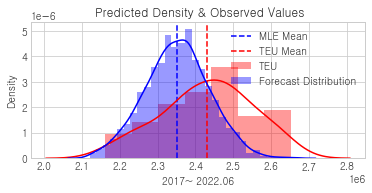

In [67]:
plt.figure(figsize=(6,2.5))
plt.title(' Predicted Density & Observed Values')
plt.axvline(x=weight, color='blue',linestyle='dashed',label='MLE Mean')
plt.axvline(x=test_data.mean(), color='red',linestyle='dashed',label='TEU Mean')
sns.distplot(test_data.reset_index()['TEU'],color='red',label='TEU',hist=True)
sns.distplot(df.transpose(),color='blue',label='Forecast Distribution',hist=True)
plt.xlabel('2017~ 2022.06')
plt.legend()

In [68]:
from scipy.stats import norm
from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import minimize

LL = -np.sum( stats.norm.logpdf(df, loc=test_data.reset_index()['TEU'].mean(), scale=test_data.reset_index()['TEU'].std() ) )
LL

23549.59290464272

In [69]:
LL = -np.sum(stats.norm.logpdf(df, loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

23793.575164154176

In [70]:
LL = -np.sum( stats.norm.logpdf(test_data.reset_index()['TEU'], loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

949.5388340761228